#   Preparing Database 

This notebook contains steps to prepare database for further analysis

## Local PostgreSQL

In [4]:
import sys
sys.path.append('..')
import seizurecast.data.make_dataset

## Prepare directory

In [5]:
def prepare_directory_table():
    """This function reads all raw data file in the given directory recursively. And create a SQL table DIRECTORY"""
    import seizurecast.data.file_io as file_io
    homedir = "/Users/yanxlin/github/ids/tusz_1_5_2/edf/train/01_tcp_ar"
    df = file_io.listdir_edfs(homedir)
    df = df.rename(columns={'path7': 'train_test'})
    df.to_sql('directory', con=SQLengine, if_exists='replace')

In [6]:
def make_dataset():
    """Reads token files from DIRECTORY and make dataset"""
    import pandas as pd
    import seizurecast.data.make_dataset as md
    from seizurecast.postgresql import SQLengine
    ds = md.make_dataset(pd.read_sql("""select token_path from directory where train_test='train' and tcp_type='01_tcp_ar' limit 1""",SQLengine).to_numpy()[0])
    return ds

## Split Train Test patients
to avoid data leakage, spit dataset on patient level

In [325]:
# randomly sample 80/20 on patient level
from sklearn.model_selection import train_test_split
patient_id = np.unique(pd.read_sql("select * from directory where train_test='train' and tcp_type='01_tcp_ar'", SQLengine).loc[:,'patient'])
patient_train, patient_test = train_test_split(patient_id, test_size=0.2, random_state=0)

print(f"Patient ID: {patient_train[0:3]} ..., \n",
    f"Number of patients in Train:\t{patient_train.shape[0]}\n",
    f"Number of patients in Test:\t{patient_test.shape[0]}\n")

Patient ID: ['00000577' '00006103' '00007936'] ..., 
 Number of patients in Train:	246
 Number of patients in Test:	62



In [326]:
# Create table patient_group, storing patient ID and their train/test association
pd.concat([
    pd.DataFrame({'patient':patient_train}).assign(train_test='train'),
    pd.DataFrame({'patient':patient_test}).assign(train_test='test')
])
.to_sql('patient_group', SQLengine, if_exists='replace')

### Average multiple channels?

Doing average over all channels does not make sense. It messes up the frequency features.


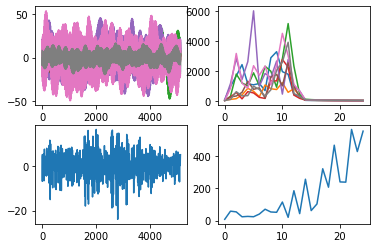

In [7]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

def plot():
    _, axes=plt.subplots(2,2)
    for i in range(0,8):
        y_i = np.concatenate(np.array(ds[0])[1000:1020, i, :].T, axis=0)
        axes[0][0].plot(y_i)
        axes[0][1].plot(np.abs(sp.fft.fft(y_i))[0:25])
    y_mean = np.mean(np.concatenate(np.array(ds[0])[1000:1020, :, :], axis=1), axis=0)
    axes[1][0].plot(y_mean)
    axes[1][1].plot(np.abs(sp.fft.fft(y_mean))[0:25])
print('Doing average over all channels does not make sense. It messes up the frequency features.')
plot()    

## Boto3 RDS

Load pre-processed dataset.

In [12]:
def connect2awsrds(config):
    import psycopg2
    import sys
    import boto3

    ENDPOINT=config['AWSRDS']['endpoint']
    PORT=config['AWSRDS']['port']
    USR=config['AWSRDS']['username']
    REGION=config['AWSRDS']['region']
    DBNAME="postgres"

    #gets the credentials from .aws/credentials
    session = boto3.Session(profile_name='default')
    client = boto3.client('rds', region_name=REGION)

    token = client.generate_db_auth_token(DBHostname=ENDPOINT, Port=PORT, DBUsername=USR, Region=REGION)                    
    
    print(token)

    try:
        conn = psycopg2.connect(host=ENDPOINT, port=PORT, database=DBNAME, user=USR, password=token)
        cur = conn.cursor()
        cur.execute("""SELECT now()""")
        query_results = cur.fetchall()
        print(query_results)
    except Exception as e:
        print("Database connection failed due to {}".format(e))    
    
    return conn

# import configparser

# config = configparser.ConfigParser()
# config.read("/Users/yanxlin/github/ids/aws/aws-rds-cred")
# conn = connect2awsrds(config)


In [3]:
import configparser

config = configparser.ConfigParser()
config.read("~/github/ids/aws/aws-rds-cred")
config['AWSRDS']['endpoint']

'database-1.cy4tbgufad6a.us-east-2.rds.amazonaws.com:5432'